<a href="https://colab.research.google.com/github/FabioERodrigues/sentiment-analysis-python/blob/main/FinalYear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

Fabio Rodrigues
31016067

In [ ]:
import os
import re
import shutil
import tarfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import spacy
import tensorflow as tf
from bs4 import BeautifulSoup
from collections import Counter
from scipy.stats import uniform
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier,
    AdaBoostClassifier
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from transformers import (
    BertTokenizer, TFBertForSequenceClassification
)
from wordcloud import WordCloud, STOPWORDS
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
import time

In [ ]:
movies = "/content/rotten_tomatoes_movies.csv"
movie_review = "/content/rotten_tomatoes_movie_reviews.csv"

In [ ]:
df1 = pd.read_csv(movies, encoding='latin-1')
df2 = pd.read_csv(movie_review, encoding='latin-1')

MERGING THE datasets

In [ ]:
# Performs an inner merge on the 'id' column
merged_df = pd.merge(df1, df2, on='id', how='inner')

# Displays the first few rows of the merged DataFrame
print(merged_df.head())

            id       title  audienceScore  tomatoMeter rating  \
0    love_lies  Love, Lies           43.0          NaN    NaN   
1    love_lies  Love, Lies           43.0          NaN    NaN   
2  adrift_2018      Adrift           65.0         69.0  PG-13   
3  adrift_2018      Adrift           65.0         69.0  PG-13   
4  adrift_2018      Adrift           65.0         69.0  PG-13   

                                      ratingContents releaseDateTheaters  \
0                                                NaN                 NaN   
1                                                NaN                 NaN   
2  ['Injury Images', 'Brief Drug Use', 'Thematic ...          2018-06-01   
3  ['Injury Images', 'Brief Drug Use', 'Thematic ...          2018-06-01   
4  ['Injury Images', 'Brief Drug Use', 'Thematic ...          2018-06-01   

  releaseDateStreaming  runtimeMinutes                      genre  ...  \
0                  NaN           120.0                      Drama  ...   
1   

#Exploratory Data Analysis(EDA)



In [ ]:
merged_df.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,...,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,...,2739073,2020-10-31,James Mudge,False,4/5,fresh,easternKicks.com,Though let down by its routine love triangle n...,POSITIVE,https://www.easternkicks.com/reviews/love-lies
1,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,...,2333658,2016-06-15,Diva Velez,False,3.5/5,fresh,TheDivaReview.com,"While not perfect, Love, Lies is a worthy disc...",POSITIVE,http://thedivareview.com/Love_Lies_Movie_Revie...
2,adrift_2018,Adrift,65.0,69.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic ...",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",...,102694850,2022-05-29,Josh Parham,False,6/10,fresh,Next Best Picture,This is nowhere near the level of other great ...,POSITIVE,https://www.nextbestpicture.com/adrift.html
3,adrift_2018,Adrift,65.0,69.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic ...",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",...,102654799,2022-02-11,Cory Woodroof,False,NaN,fresh,615 Film,"Adrift somehow survives the late reveal, and t...",POSITIVE,https://615film.wordpress.com/2018/06/07/the-p...
4,adrift_2018,Adrift,65.0,69.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic ...",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",...,2816011,2021-08-21,Kip Mooney,False,C+,rotten,College Movie Review,"For almost the entire runtime, the only people...",NEGATIVE,https://collegemoviereview.com/featured/review...


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469543 entries, 0 to 1469542
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1469543 non-null  object 
 1   title                 1464073 non-null  object 
 2   audienceScore         1399294 non-null  float64
 3   tomatoMeter           1398270 non-null  float64
 4   rating                889498 non-null   object 
 5   ratingContents        889498 non-null   object 
 6   releaseDateTheaters   1184070 non-null  object 
 7   releaseDateStreaming  1355722 non-null  object 
 8   runtimeMinutes        1440071 non-null  float64
 9   genre                 1446093 non-null  object 
 10  originalLanguage      1439891 non-null  object 
 11  director              1460521 non-null  object 
 12  writer                1311318 non-null  object 
 13  boxOffice             1010267 non-null  object 
 14  distributor           1133821 non-

In [ ]:
merged_df.nunique()

,0
id,69260
title,63405
audienceScore,101
tomatoMeter,101
rating,8
ratingContents,7365
releaseDateTheaters,9499
releaseDateStreaming,4289
runtimeMinutes,289
genre,2178


In [ ]:
merged_df.isnull().sum()

,0
id,0
title,5470
audienceScore,70249
tomatoMeter,71273
rating,580045
ratingContents,580045
releaseDateTheaters,285473
releaseDateStreaming,113821
runtimeMinutes,29472
genre,23450


In [ ]:
(merged_df.isnull().sum()/(len(merged_df)))*100 # perectange of null values in ecery column

,0
id,0.000000
title,0.372225
audienceScore,4.780330
tomatoMeter,4.850011
rating,39.471114
ratingContents,39.471114
releaseDateTheaters,19.425971
releaseDateStreaming,7.745333
runtimeMinutes,2.005521
genre,1.595734


In [ ]:
# REMOVING irrelavant COLUMNS

columns_to_drop = [
     'tomatoMeter', 'ratingContents',
    'runtimeMinutes', 'originalLanguage', 'director', 'writer',
    'boxOffice', 'distributor', 'soundMix', 'reviewState',
    'publicatioName', 'reviewUrl',  'releaseDateTheaters', 'releaseDateStreaming', 'reviewId', 'creationDate', 'criticName', 'rating', 'originalScore'
]

merged_df = merged_df.drop(columns=columns_to_drop)


In [ ]:
merged_df.head()

,id,title,audienceScore,genre,isTopCritic,reviewText,scoreSentiment
0,love_lies,"Love, Lies",43.0,Drama,False,Though let down by its routine love triangle n...,POSITIVE
1,love_lies,"Love, Lies",43.0,Drama,False,"While not perfect, Love, Lies is a worthy disc...",POSITIVE
2,adrift_2018,Adrift,65.0,"Adventure, Drama, Romance",False,This is nowhere near the level of other great ...,POSITIVE
3,adrift_2018,Adrift,65.0,"Adventure, Drama, Romance",False,"Adrift somehow survives the late reveal, and t...",POSITIVE
4,adrift_2018,Adrift,65.0,"Adventure, Drama, Romance",False,"For almost the entire runtime, the only people...",NEGATIVE


In [ ]:
merged_df['reviewText'] = merged_df['reviewText'].astype(str)

##Wordcloud

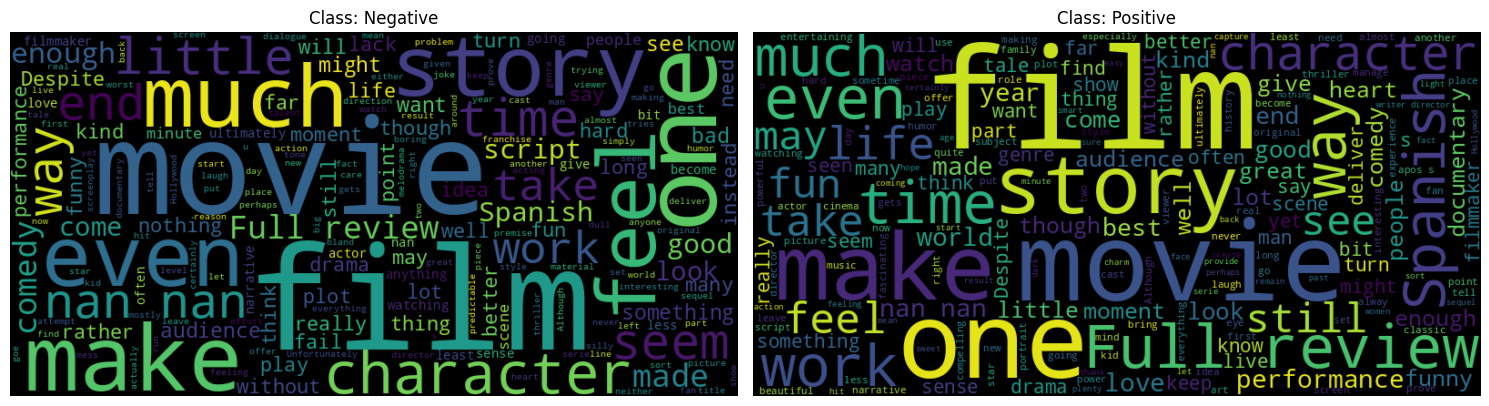

In [ ]:
# Concatenate reviews by sentiment
negative_reviews = ' '.join(merged_df[merged_df['scoreSentiment'] == "NEGATIVE"]['reviewText'])
positive_reviews = ' '.join(merged_df[merged_df['scoreSentiment'] == "POSITIVE"]['reviewText'])

# Generate word clouds
wordcloud_neg = WordCloud(width=800, height=400).generate(negative_reviews)
wordcloud_pos = WordCloud(width=800, height=400).generate(positive_reviews)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Negative Reviews WordCloud
axes[0].imshow(wordcloud_neg, interpolation='bilinear')
axes[0].set_title('Class: Negative')
axes[0].axis('off')

# Plot Positive Reviews WordCloud
axes[1].imshow(wordcloud_pos, interpolation='bilinear')
axes[1].set_title('Class: Positive')
axes[1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# words like good appear in negative class after looking into it i found a few example i found why this might be for example
#"It doesn't matter if a movie costs 300 million or only 300 dollars; good is good and bad is bad, and Bloodmask: The Possession of Nicole Lameroux is just plain bad."
#reviews like this might explain why good appears in  negative class
 #another example
#"In the comic context of A Gorgeous Bird Like Me, a good deal of the savour is lost simply because this femme comes over as much less fatale than may have been intended."
#Director Joel Schumacher, credited with toning down Ebbe Roe Smith's script, paces the film rivetingly, which goes to show that good film-making doesn't guarantee a good film. Falling Down is as sleek and efficient as a torture chamber.


##Distribution of Review length

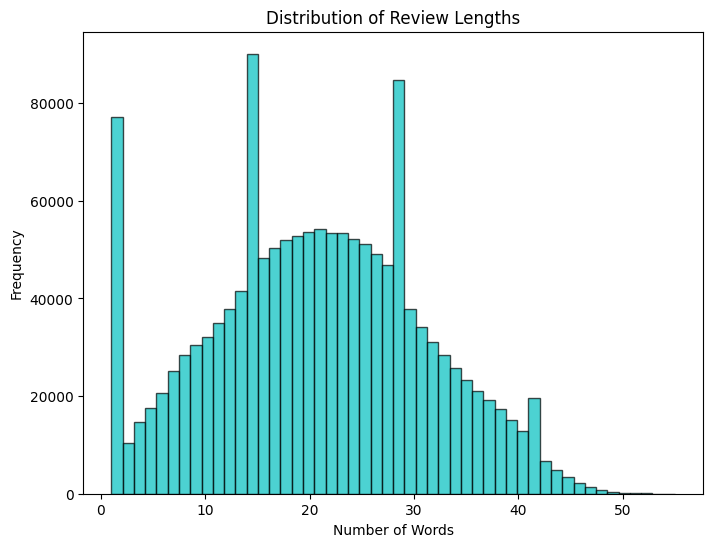

In [ ]:
# Calculate review lengths
merged_df['review_length'] = merged_df['reviewText'].apply(lambda x: len(x.split()))

# Plotting the distribution of review lengths
plt.figure(figsize=(8, 6))
plt.hist(merged_df['review_length'], bins=50, color='c', edgecolor='k', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Sentiment distribution

In [ ]:
#Sentiment distribution
sentiment_counts = merged_df['scoreSentiment'].value_counts()

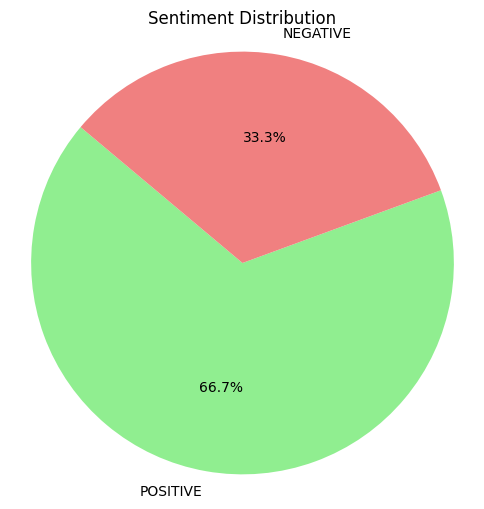

In [ ]:
#Sentiment distribution visulaised using pie chart
# Pie chart for sentiment distribution
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightcoral'],
    startangle=140
)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

#Pre-Processing


In [ ]:
#Removing 0 t0 5 word reviews
print(merged_df.shape)
# Remove reviews with 5 word or less
merged_df = merged_df[merged_df['review_length'] > 5]

# Reset index
merged_df = merged_df.reset_index(drop=True)

# Verify the changes
print(merged_df.shape)

(1469543, 8)
(1349608, 8)


In [ ]:
merged_df = merged_df.dropna(subset=['reviewText'])
merged_df = merged_df.dropna(subset=['title'])
merged_df = merged_df.dropna(subset=['audienceScore'])
merged_df = merged_df.dropna(subset=['genre'])
merged_df = merged_df.dropna(subset=['scoreSentiment'])

# Double-check if any NaN values remain
print(merged_df.isnull().sum())
# Check if y has NaN values
print((merged_df.applymap(lambda x: x.strip() == "" if isinstance(x, str) else False)).sum())
print((merged_df.applymap(lambda x: x.strip() == "" if isinstance(x, str) else False)).sum())
print((merged_df.isin([None])).sum())
print((merged_df.isin(["NULL", "NA", "-"])).sum())

print(merged_df.dtypes)


id                0
title             0
audienceScore     0
genre             0
isTopCritic       0
reviewText        0
scoreSentiment    0
review_length     0
dtype: int64


<ipython-input-20-8e85b4c9d32c>:10: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



id                0
title             0
audienceScore     0
genre             0
isTopCritic       0
reviewText        0
scoreSentiment    0
review_length     0
dtype: int64


<ipython-input-20-8e85b4c9d32c>:11: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



id                0
title             0
audienceScore     0
genre             0
isTopCritic       0
reviewText        0
scoreSentiment    0
review_length     0
dtype: int64
id                0
title             0
audienceScore     0
genre             0
isTopCritic       0
reviewText        0
scoreSentiment    0
review_length     0
dtype: int64
id                0
title             0
audienceScore     0
genre             0
isTopCritic       0
reviewText        0
scoreSentiment    0
review_length     0
dtype: int64
id                 object
title              object
audienceScore     float64
genre              object
isTopCritic          bool
reviewText         object
scoreSentiment     object
review_length       int64
dtype: object


In [ ]:
print(merged_df["scoreSentiment"].unique())

['POSITIVE' 'NEGATIVE']


In [ ]:
merged_df.shape

(1273755, 8)

In [ ]:
#Removing special characters for the reviewtext
#Preprocess the 'text' column
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags symbol
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

merged_df['reviewText'] = merged_df['reviewText'].apply(clean_text)

In [ ]:
#Sample 100,000 to tokenize for model testing

sampled_df = merged_df.sample(n=10000, random_state=42)

In [ ]:
sampled_df["scoreSentiment"] = sampled_df["scoreSentiment"].map({"POSITIVE": 1, "NEGATIVE": 0})

In [ ]:
sampled_df.dtypes

,0
id,object
title,object
audienceScore,float64
genre,object
isTopCritic,bool
reviewText,object
scoreSentiment,int64
review_length,int64


In [ ]:
print(sampled_df["scoreSentiment"].unique())

[1 0]


In [ ]:
print(sampled_df.isnull().sum())

id                0
title             0
audienceScore     0
genre             0
isTopCritic       0
reviewText        0
scoreSentiment    0
review_length     0
dtype: int64


In [ ]:
sampled_df.head(5)

,id,title,audienceScore,genre,isTopCritic,reviewText,scoreSentiment,review_length
393818,portrait_of_a_lady_on_fire,Portrait of a Lady on Fire,92.0,"Romance, History, Drama, Lgbtq+",False,director celine sciamma has made something far...,1,26
75292,the_courier,The Courier,95.0,"Mystery & thriller, History, Drama",False,the movie did make me want to go back and rewa...,1,14
945722,wedding_bros,The Marconi Bros.,6.0,"Comedy, Drama",False,its not that the story is hard to fathom rathe...,0,27
416964,dead_snow,Dead Snow,56.0,"Horror, Comedy",False,the sprightliest movie about mowing down reven...,1,18
174055,tell_me_who_i_am,Tell Me Who I Am,87.0,Drama,False,tell me who i am is a captivating look at two ...,1,38


#Machine learning methods

In [ ]:
#Traditional models

In [ ]:
nlp= spacy.load('en_core_web_sm')

##Negation, Lemmatization and tokenisation

In [ ]:
def process_text(s):
    doc = nlp(s)
    out = []
    negation = False
    for token in doc:
        if token.dep_ == 'neg':  # Detect negation
            negation = True
        elif token.is_punct:
            negation = False

        if not token.is_stop and not token.is_punct:
            lemma = token.lemma_.lower()
            if negation:
                lemma = f"not_{lemma}"
                negation = False  # Reset after handling
            out.append(lemma)
    return ' '.join(out)

In [ ]:
sampled_df['fltrTxt']= sampled_df['reviewText'].apply(process_text)

In [ ]:
# after first doing the cod there was overfitting which i found out due to getting 100% accuracy on some of ml models so some changes were made to combat this problem

In [ ]:
# Split the dataset into training and testing sets
X = sampled_df['fltrTxt']
y = sampled_df['scoreSentiment']

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Now apply TF-IDF vectorization only on the training set and transform the test set
vct = TfidfVectorizer(max_features=10_000, stop_words='english', ngram_range=(1,2))
X_trn = vct.fit_transform(X_trn)
X_tst = vct.transform(X_tst)  # Transform test set with the same vectorizer


In [ ]:
def model_report(model, verbose=True):
    model.fit(X_trn, y_trn)

    # Start timing for training
    train_start = time.time()
    model.fit(X_trn, y_trn)
    train_end = time.time()
    train_time = train_end - train_start
    # Start timing for inference
    inference_start = time.time()
    y_pred = model.predict(X_tst)
    inference_end = time.time()
    inference_time = inference_end - inference_start
    trnScore = model.score(X_trn, y_trn)
    tstScore = model.score(X_tst, y_tst)
    cm = confusion_matrix(y_tst, y_pred)
    cr = classification_report(y_tst, y_pred)

    if verbose:
        print('Train Score: %f' % trnScore)
        print('Test Score: %f' % tstScore)
        print('Training Time: %.2f seconds' % train_time)
        print('Inference Time: %.2f seconds' % inference_time)
        print('Classification Report:\n', cr)
        ConfusionMatrixDisplay(cm).plot()
        plt.show()
        print()

    return {
        'trn': trnScore,
        'tst': tstScore,
        'cm': cm,
        'cr': cr,
        'train_time': train_time,
        'inference_time': inference_time
    }

In [ ]:
models_dict= {
	'LogisticRegression':     LogisticRegression(max_iter=10_000, class_weight='balanced'),
	'Support Vector':         SVC(class_weight='balanced'),
	'KNeighborsCLassifier':   KNeighborsClassifier(n_neighbors=15), # to fix overfiiting
	'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', max_depth=10), # Prevent overfitting
	'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'),
	'BaggingClassifier':      BaggingClassifier(),
	'ExtraTreesClassifier':   ExtraTreesClassifier(class_weight='balanced'),
	'AdaBoostClassifier':     AdaBoostClassifier(),
	'XGBClassifier':          XGBClassifier( n_estimators=100, max_depth=3),# Shallow trees help avoid overfitting
	'LGBMClassifier':         LGBMClassifier(class_weight='balanced'),
}
models= [{'name':k, 'obj':v} for k,v in models_dict.items()]

i= 0
for model in models:
	print("Evaluating %s..."%model['name'])
	print("%d/%d models"%(i, len(models)), end='\r')
	model.update(model_report(model['obj'], verbose=False))
	i+= 1
print("%d/%d models evaluated"%(i, len(models)))
print("done")

Evaluating LogisticRegression...
Evaluating Support Vector...
Evaluating KNeighborsCLassifier...
Evaluating DecisionTreeClassifier...
Evaluating RandomForestClassifier...
Evaluating BaggingClassifier...
Evaluating ExtraTreesClassifier...
Evaluating AdaBoostClassifier...
Evaluating XGBClassifier...
Evaluating LGBMClassifier...
[LightGBM] [Info] Number of positive: 5351, number of negative: 2649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15093
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 778
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Info] Number of positive: 5351, number of negative: 2649
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15093
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 778
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
10/10 models evaluated
done


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



## Train score and test score for traditional machine learning models

In [ ]:
ml_results_df = pd.DataFrame({
	'Algorithm':           [model['name'] for model in models],
	'Train Score':         [model['trn']  for model in models],
	'Test Score':          [model['tst']  for model in models],
	'train time':          [model['train_time']  for model in models],
	'Inference time':      [model['inference_time']  for model in models],
}).set_index('Algorithm').sort_values(by='Test Score', ascending=False)

print("Traditional ML Models Performance:")
print(ml_results_df)

Traditional ML Models Performance:
                        Train Score  Test Score  train time  Inference time
Algorithm                                                                  
Support Vector             0.991250      0.7455   10.967495        1.825069
LogisticRegression         0.888000      0.7165    0.031042        0.000486
ExtraTreesClassifier       1.000000      0.7115   12.767762        0.271733
XGBClassifier              0.754750      0.7055    0.555994        0.002967
RandomForestClassifier     1.000000      0.6925    9.400218        0.201314
AdaBoostClassifier         0.675125      0.6735    0.851512        0.021869
LGBMClassifier             0.790750      0.6645    0.333062        0.004999
KNeighborsCLassifier       0.749500      0.6590    0.001061        0.310081
DecisionTreeClassifier     0.698750      0.6560    0.166753        0.000853
BaggingClassifier          0.978500      0.6455   30.431918        0.035503


## Classification Report

In [ ]:
for model in models:
	print(model['name'])
	print(model['cr'])

LogisticRegression
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       662
           1       0.81      0.75      0.78      1338

    accuracy                           0.72      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.73      0.72      0.72      2000

Support Vector
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       662
           1       0.79      0.84      0.81      1338

    accuracy                           0.75      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.74      0.75      0.74      2000

KNeighborsCLassifier
              precision    recall  f1-score   support

           0       0.49      0.62      0.55       662
           1       0.78      0.68      0.73      1338

    accuracy                           0.66      2000
   macro avg       0.64      0.65      0.64      2000
weighted avg       

## Hyperparemeter tuning for best performing traditional ml models: SVC, logistic regresiion and Extratress classifier

###Grid search

In [ ]:
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’, ‘poly’
}

grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_trn, y_trn)

print("Best parameters for SVC:", grid_svc.best_params_)
print("Best SVC Score:", grid_svc.best_score_)

Best parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVC Score: 0.7471249999999999


In [ ]:
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Solver type (for L1, use 'liblinear' or 'saga')
}

grid_logreg = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_trn, y_trn)

print("Best parameters for Logistic Regression:", grid_logreg.best_params_)
print("Best Logistic Regression Score:", grid_logreg.best_score_)

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression Score: 0.74


###Randomised search

In [ ]:
param_dist_extratrees = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None]  # Features to consider per split
}
# Use RandomizedSearchCV
random_extratrees = RandomizedSearchCV(
    ExtraTreesClassifier(),
    param_distributions=param_dist_extratrees,
    n_iter=20,  # Number of random parameter combinations to try
    cv=3,  # Reduce cross-validation folds to speed up training
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # For reproducibility
)
# Fit the model
random_extratrees.fit(X_trn, y_trn)
# Print best parameters and score
print("Best parameters for Extra Trees:", random_extratrees.best_params_)
print("Best Extra Trees Score:", random_extratrees.best_score_)

Best parameters for Extra Trees: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Best Extra Trees Score: 0.7252495538582808


#BERT

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Spliting data FIRST to prevent leakage  which happned in the last code
# First split: 80% train, 20% test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    sampled_df['reviewText'],
    sampled_df['scoreSentiment'],
    test_size=0.2,
    stratify=sampled_df['scoreSentiment'],
    random_state=99
)

In [ ]:
# Second split: 80% of original -> 80% train (64% total), 20% validation (16% total)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=99
)

In [ ]:
#Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

# 3. Tokenization function
def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='tf'
    )
# Encode all splits(imp for bert)
train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Convert to TensorFlow Dataset for better performance
def create_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    )).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(train_encodings, train_labels)
val_dataset = create_dataset(val_encodings, val_labels)
test_dataset = create_dataset(test_encodings, test_labels)

In [ ]:
#Model setup
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Configure training
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# 7. Train the model
# Function to measure training time
def time_bert_training(model, train_dataset, val_dataset, epochs=5):
    # Start timing for training
    train_start = time.time()

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1
    )

    train_end = time.time()
    train_time = train_end - train_start

    print(f'BERT Training Time: {train_time:.2f} seconds')
    return history, train_time

# Function to measure inference time
def time_bert_inference(model, test_dataset):
    # Start timing for inference
    inference_start = time.time()

    # Run prediction
    predictions = model.predict(test_dataset)

    inference_end = time.time()
    inference_time = inference_end - inference_start

    # Get the number of test examples
    num_examples = sum(batch[1].shape[0] for batch in test_dataset)
    per_example_time = inference_time / num_examples

    print(f'BERT Inference Time: {inference_time:.2f} seconds')
    print(f'Time per example: {per_example_time*1000:.2f} ms')

    return predictions, inference_time

In [ ]:
#Full evaluation
history, bert_train_time = time_bert_training(model, train_dataset, val_dataset)
predictions, bert_inference_time = time_bert_inference(model, test_dataset)
y_pred = predictions.logits.argmax(axis=1)

print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

#Confusion matrix
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

Epoch 1/5
200/200 [==============================] - 77s 156ms/step - loss: 0.4393 - accuracy: 0.7930 - val_loss: 0.3927 - val_accuracy: 0.8300
Epoch 2/5
200/200 [==============================] - 21s 106ms/step - loss: 0.2718 - accuracy: 0.8920 - val_loss: 0.4037 - val_accuracy: 0.8263
Epoch 3/5
200/200 [==============================] - 21s 104ms/step - loss: 0.1818 - accuracy: 0.9339 - val_loss: 0.4656 - val_accuracy: 0.8344
Epoch 4/5
200/200 [==============================] - 21s 105ms/step - loss: 0.0941 - accuracy: 0.9695 - val_loss: 0.5454 - val_accuracy: 0.8350
Epoch 5/5
200/200 [==============================] - 21s 104ms/step - loss: 0.0442 - accuracy: 0.9881 - val_loss: 0.7063 - val_accuracy: 0.8238
BERT Training Time: 160.81 seconds
63/63 [==============================] - 6s 38ms/step
BERT Inference Time: 5.97 seconds
Time per example: 2.98 ms

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73       66

In [ ]:
# After the training code block:

# Get scores for FINAL MODEL
train_loss, train_acc = model.evaluate(train_dataset, verbose=0)
val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)

# Create comprehensive results table
results_df = pd.DataFrame({
    'Algorithm': ['BERT'],
    'Train Score': [train_acc],
    'Test Score': [test_acc],
    'train time': [bert_train_time],
    'Inference time': [bert_inference_time]
})
print("\nModel Performance:")
print(results_df.round(4))

# Optional: Compare with last epoch's training accuracy
final_epoch_train_acc = history.history['accuracy'][-1]
print(f"\nLast Epoch Training Accuracy: {final_epoch_train_acc:.4f}")


Model Performance:
  Algorithm  Train Score  Test Score  train time  Inference time
0      BERT       0.9927      0.8325    160.8124          5.9663

Last Epoch Training Accuracy: 0.9881


# Hyper tuning for bert


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define hyperparameter grid
learning_rates = [5e-5, 4e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]

# Ensure dataset columns exist
assert 'reviewText' in sampled_df and 'scoreSentiment' in sampled_df, "Dataset columns missing!"

# Split data into train / val / test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    sampled_df['reviewText'].tolist(),
    sampled_df['scoreSentiment'].tolist(),
    test_size=0.2,
    stratify=sampled_df['scoreSentiment'],
    random_state=99
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=99
)

# Tokenization helper
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf"
    )

# Encode all splits
train_encodings = encode_texts(train_texts, tokenizer)
val_encodings   = encode_texts(val_texts, tokenizer)
test_encodings  = encode_texts(test_texts, tokenizer)

# Create tf.data.Dataset
def create_dataset(encodings, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Grid search over all combinations
best_val_accuracy = 0.0
best_params = {}
trial_num = 0

total_trials = len(learning_rates) * len(batch_sizes)
print(f"Starting grid search over {total_trials} trials...\n")

for lr in learning_rates:
    for batch_size in batch_sizes:
        trial_num += 1
        print(f"Trial {trial_num}/{total_trials}: lr={lr}, batch_size={batch_size}")

        # Prepare datasets
        train_ds = create_dataset(train_encodings, train_labels, batch_size)
        val_ds   = create_dataset(val_encodings,   val_labels,   batch_size)
        test_ds  = create_dataset(test_encodings,  test_labels,  batch_size)

        # Initialize and compile model
        model = TFBertForSequenceClassification.from_pretrained(
            "bert-base-uncased", num_labels=2
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        # Train
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=5,
            verbose=1
        )

        # Evaluate
        max_train_acc = max(history.history['accuracy'])
        max_val_acc   = max(history.history['val_accuracy'])
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)

        print(f"  --> Train Acc: {max_train_acc:.4f}, Val Acc: {max_val_acc:.4f}, Test Acc: {test_acc:.4f}\n")

        # Update best
        if max_val_acc > best_val_accuracy:
            best_val_accuracy = max_val_acc
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'best_train_accuracy': max_train_acc,
                'best_val_accuracy': max_val_acc,
                'test_accuracy': test_acc
            }

# Final results
print("Grid search complete. Best hyperparameters and performance:", best_params)

Starting grid search over 8 trials...

Trial 1/8: lr=5e-05, batch_size=16


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
400/400 [==============================] - 81s 101ms/step - loss: 0.4436 - accuracy: 0.7903 - val_loss: 0.3771 - val_accuracy: 0.8381
Epoch 2/5
400/400 [==============================] - 26s 65ms/step - loss: 0.2275 - accuracy: 0.9137 - val_loss: 0.4761 - val_accuracy: 0.8325
Epoch 3/5
400/400 [==============================] - 26s 65ms/step - loss: 0.1106 - accuracy: 0.9608 - val_loss: 0.6312 - val_accuracy: 0.8319
Epoch 4/5
400/400 [==============================] - 26s 66ms/step - loss: 0.0747 - accuracy: 0.9750 - val_loss: 0.6216 - val_accuracy: 0.8306
Epoch 5/5
400/400 [==============================] - 26s 65ms/step - loss: 0.0552 - accuracy: 0.9828 - val_loss: 0.5943 - val_accuracy: 0.8306
  --> Train Acc: 0.9828, Val Acc: 0.8381, Test Acc: 0.8305

Trial 2/8: lr=5e-05, batch_size=32


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
200/200 [==============================] - 68s 148ms/step - loss: 0.4382 - accuracy: 0.7908 - val_loss: 0.3629 - val_accuracy: 0.8331
Epoch 2/5
200/200 [==============================] - 16s 81ms/step - loss: 0.2315 - accuracy: 0.9045 - val_loss: 0.5831 - val_accuracy: 0.8244
Epoch 3/5
200/200 [==============================] - 16s 81ms/step - loss: 0.1425 - accuracy: 0.9530 - val_loss: 0.5820 - val_accuracy: 0.8300
Epoch 4/5
200/200 [==============================] - 16s 81ms/step - loss: 0.0937 - accuracy: 0.9642 - val_loss: 0.5596 - val_accuracy: 0.8031
Epoch 5/5
200/200 [==============================] - 16s 81ms/step - loss: 0.0600 - accuracy: 0.9797 - val_loss: 0.6099 - val_accuracy: 0.8325
  --> Train Acc: 0.9797, Val Acc: 0.8331, Test Acc: 0.8270

Trial 3/8: lr=4e-05, batch_size=16


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
400/400 [==============================] - 79s 101ms/step - loss: 0.4536 - accuracy: 0.7802 - val_loss: 0.3858 - val_accuracy: 0.8381
Epoch 2/5
400/400 [==============================] - 26s 66ms/step - loss: 0.2337 - accuracy: 0.9075 - val_loss: 0.4553 - val_accuracy: 0.8300
Epoch 3/5
400/400 [==============================] - 26s 66ms/step - loss: 0.1256 - accuracy: 0.9558 - val_loss: 0.5964 - val_accuracy: 0.8144
Epoch 4/5
400/400 [==============================] - 26s 65ms/step - loss: 0.0729 - accuracy: 0.9767 - val_loss: 0.7448 - val_accuracy: 0.8300
Epoch 5/5
400/400 [==============================] - 26s 66ms/step - loss: 0.0594 - accuracy: 0.9836 - val_loss: 0.6802 - val_accuracy: 0.8225
  --> Train Acc: 0.9836, Val Acc: 0.8381, Test Acc: 0.8265

Trial 4/8: lr=4e-05, batch_size=32


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
200/200 [==============================] - 71s 143ms/step - loss: 0.4461 - accuracy: 0.7853 - val_loss: 0.3584 - val_accuracy: 0.8438
Epoch 2/5
200/200 [==============================] - 16s 82ms/step - loss: 0.2538 - accuracy: 0.8983 - val_loss: 0.4444 - val_accuracy: 0.8369
Epoch 3/5
200/200 [==============================] - 16s 82ms/step - loss: 0.1447 - accuracy: 0.9467 - val_loss: 0.6668 - val_accuracy: 0.8025
Epoch 4/5
200/200 [==============================] - 16s 82ms/step - loss: 0.0783 - accuracy: 0.9739 - val_loss: 0.5827 - val_accuracy: 0.8231
Epoch 5/5
200/200 [==============================] - 16s 82ms/step - loss: 0.0386 - accuracy: 0.9870 - val_loss: 0.6767 - val_accuracy: 0.8438
  --> Train Acc: 0.9870, Val Acc: 0.8438, Test Acc: 0.8335

Trial 5/8: lr=3e-05, batch_size=16


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
400/400 [==============================] - 81s 102ms/step - loss: 0.4334 - accuracy: 0.7967 - val_loss: 0.3740 - val_accuracy: 0.8444
Epoch 2/5
400/400 [==============================] - 26s 66ms/step - loss: 0.2444 - accuracy: 0.8997 - val_loss: 0.4303 - val_accuracy: 0.8512
Epoch 3/5
400/400 [==============================] - 26s 66ms/step - loss: 0.1133 - accuracy: 0.9630 - val_loss: 0.5224 - val_accuracy: 0.8119
Epoch 4/5
400/400 [==============================] - 27s 66ms/step - loss: 0.0674 - accuracy: 0.9775 - val_loss: 0.7165 - val_accuracy: 0.8288
Epoch 5/5
400/400 [==============================] - 26s 65ms/step - loss: 0.0504 - accuracy: 0.9847 - val_loss: 0.6431 - val_accuracy: 0.8300
  --> Train Acc: 0.9847, Val Acc: 0.8512, Test Acc: 0.8310

Trial 6/8: lr=3e-05, batch_size=32


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
200/200 [==============================] - 70s 143ms/step - loss: 0.4550 - accuracy: 0.7839 - val_loss: 0.3691 - val_accuracy: 0.8475
Epoch 2/5
200/200 [==============================] - 16s 82ms/step - loss: 0.2732 - accuracy: 0.8889 - val_loss: 0.4237 - val_accuracy: 0.8306
Epoch 3/5
200/200 [==============================] - 16s 82ms/step - loss: 0.1382 - accuracy: 0.9483 - val_loss: 0.5505 - val_accuracy: 0.7956
Epoch 4/5
200/200 [==============================] - 16s 82ms/step - loss: 0.0994 - accuracy: 0.9648 - val_loss: 0.4148 - val_accuracy: 0.8319
Epoch 5/5
200/200 [==============================] - 16s 82ms/step - loss: 0.0588 - accuracy: 0.9800 - val_loss: 0.6274 - val_accuracy: 0.8256
  --> Train Acc: 0.9800, Val Acc: 0.8475, Test Acc: 0.8330

Trial 7/8: lr=2e-05, batch_size=16


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
400/400 [==============================] - 79s 101ms/step - loss: 0.4366 - accuracy: 0.7989 - val_loss: 0.3716 - val_accuracy: 0.8400
Epoch 2/5
400/400 [==============================] - 26s 66ms/step - loss: 0.2552 - accuracy: 0.8947 - val_loss: 0.4470 - val_accuracy: 0.8388
Epoch 3/5
400/400 [==============================] - 27s 66ms/step - loss: 0.1442 - accuracy: 0.9516 - val_loss: 0.4635 - val_accuracy: 0.8350
Epoch 4/5
400/400 [==============================] - 26s 66ms/step - loss: 0.0775 - accuracy: 0.9736 - val_loss: 0.6263 - val_accuracy: 0.8356
Epoch 5/5
400/400 [==============================] - 26s 66ms/step - loss: 0.0547 - accuracy: 0.9833 - val_loss: 0.6424 - val_accuracy: 0.8238
  --> Train Acc: 0.9833, Val Acc: 0.8400, Test Acc: 0.8335

Trial 8/8: lr=2e-05, batch_size=32


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
200/200 [==============================] - 71s 143ms/step - loss: 0.4771 - accuracy: 0.7664 - val_loss: 0.3951 - val_accuracy: 0.8400
Epoch 2/5
200/200 [==============================] - 16s 82ms/step - loss: 0.3050 - accuracy: 0.8733 - val_loss: 0.3889 - val_accuracy: 0.8263
Epoch 3/5
200/200 [==============================] - 16s 82ms/step - loss: 0.1740 - accuracy: 0.9348 - val_loss: 0.4584 - val_accuracy: 0.8213
Epoch 4/5
200/200 [==============================] - 16s 82ms/step - loss: 0.1071 - accuracy: 0.9605 - val_loss: 0.6264 - val_accuracy: 0.8263
Epoch 5/5
200/200 [==============================] - 16s 82ms/step - loss: 0.0580 - accuracy: 0.9802 - val_loss: 0.6457 - val_accuracy: 0.8319
  --> Train Acc: 0.9802, Val Acc: 0.8400, Test Acc: 0.8325

Grid search complete. Best hyperparameters and performance: {'learning_rate': 3e-05, 'batch_size': 16, 'best_train_accuracy': 0.9846875071525574, 'best_val_accuracy': 0.8512499928474426, 'test_accuracy': 0.8309999704360962}


#Comparing traditional methods with BERT

In [ ]:
# Create one consistent combined dataframe with ALL metrics
ml_df = ml_results_df.reset_index().rename(columns={'Algorithm': 'Model'})
bert_df = results_df.rename(columns={'Algorithm': 'Model'})
#Concatenate with all columns preserved
combined_results = pd.concat([ml_df, bert_df], ignore_index=True)
print(combined_results)

                     Model  Train Score  Test Score  train time  \
0           Support Vector     0.991250      0.7455   10.967495   
1       LogisticRegression     0.888000      0.7165    0.031042   
2     ExtraTreesClassifier     1.000000      0.7115   12.767762   
3            XGBClassifier     0.754750      0.7055    0.555994   
4   RandomForestClassifier     1.000000      0.6925    9.400218   
5       AdaBoostClassifier     0.675125      0.6735    0.851512   
6           LGBMClassifier     0.790750      0.6645    0.333062   
7     KNeighborsCLassifier     0.749500      0.6590    0.001061   
8   DecisionTreeClassifier     0.698750      0.6560    0.166753   
9        BaggingClassifier     0.978500      0.6455   30.431918   
10                    BERT     0.992656      0.8325  160.812392   

    Inference time  
0         1.825069  
1         0.000486  
2         0.271733  
3         0.002967  
4         0.201314  
5         0.021869  
6         0.004999  
7         0.310081  
8     

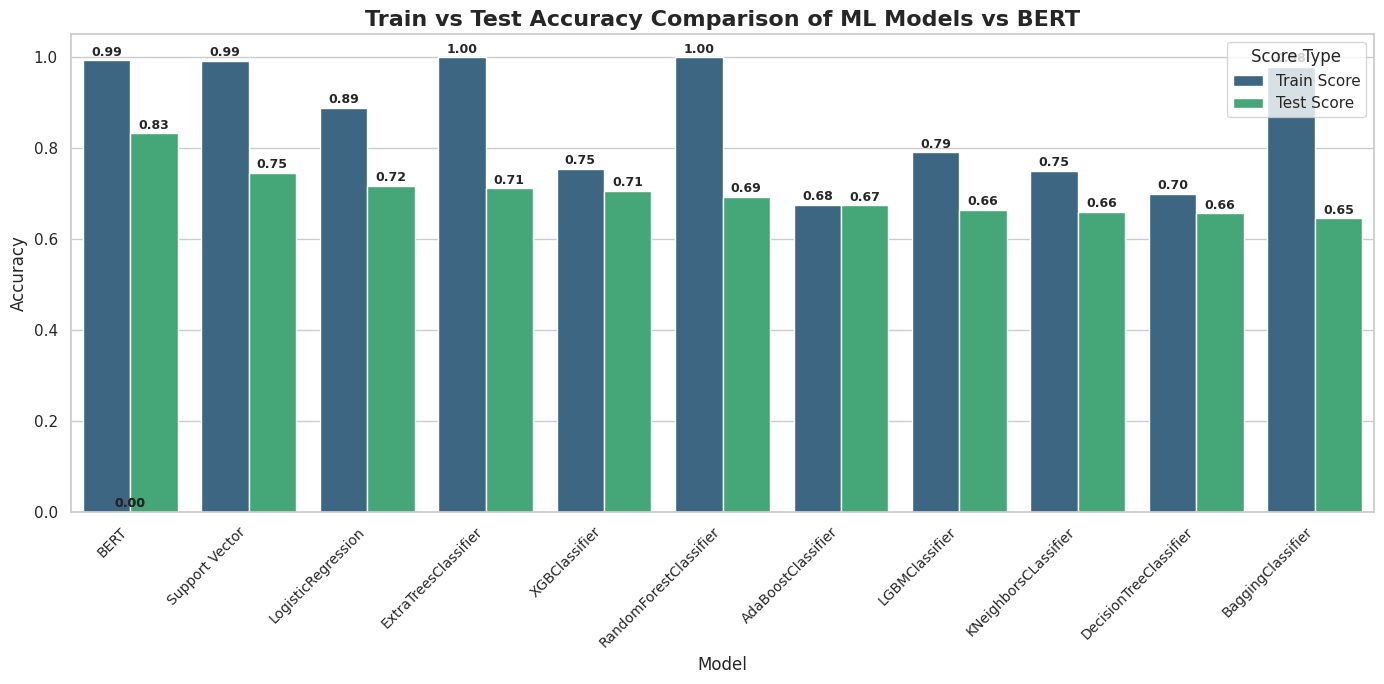

In [ ]:
# Melt the dataframe to long format for grouped bars
melted_results = pd.melt(
    combined_results,
    id_vars='Model',
    value_vars=['Train Score', 'Test Score'],
    var_name='Score Type',
    value_name='Accuracy'
)

# Sort models by test accuracy for cleaner order)
model_order = combined_results.sort_values(by='Test Score', ascending=False)['Model']
melted_results['Model'] = pd.Categorical(melted_results['Model'], categories=model_order, ordered=True)

#Plotting
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

bar = sns.barplot(
    data=melted_results,
    x='Model',
    y='Accuracy',
    hue='Score Type',
    palette='viridis'
)

# Annotate bars
for p in bar.patches:
    height = p.get_height()
    bar.annotate(
        f'{height:.2f}',
        (p.get_x() + p.get_width() / 2, height + 0.01),
        ha='center',
        fontsize=9,
        weight='bold'
    )

# Customize the plot
plt.title('Train vs Test Accuracy Comparison of ML Models vs BERT', fontsize=16, weight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.05)
plt.legend(title='Score Type', loc='upper right')
plt.tight_layout()
plt.show()

##Comparing Genearalisation across all the models

In [ ]:
#Compute the gap and sort
combined_results['Gen. Gap'] = combined_results['Train Score'] - combined_results['Test Score']
combined_results = combined_results.set_index('Model').sort_values('Gen. Gap', ascending=False)
print(combined_results)

                        Train Score  Test Score  train time  Inference time  \
Model                                                                         
BaggingClassifier          0.978500      0.6455   30.431918        0.035503   
RandomForestClassifier     1.000000      0.6925    9.400218        0.201314   
ExtraTreesClassifier       1.000000      0.7115   12.767762        0.271733   
Support Vector             0.991250      0.7455   10.967495        1.825069   
LogisticRegression         0.888000      0.7165    0.031042        0.000486   
BERT                       0.992656      0.8325  160.812392        5.966332   
LGBMClassifier             0.790750      0.6645    0.333062        0.004999   
KNeighborsCLassifier       0.749500      0.6590    0.001061        0.310081   
XGBClassifier              0.754750      0.7055    0.555994        0.002967   
DecisionTreeClassifier     0.698750      0.6560    0.166753        0.000853   
AdaBoostClassifier         0.675125      0.6735    0

<ipython-input-57-ac00d3c42df7>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




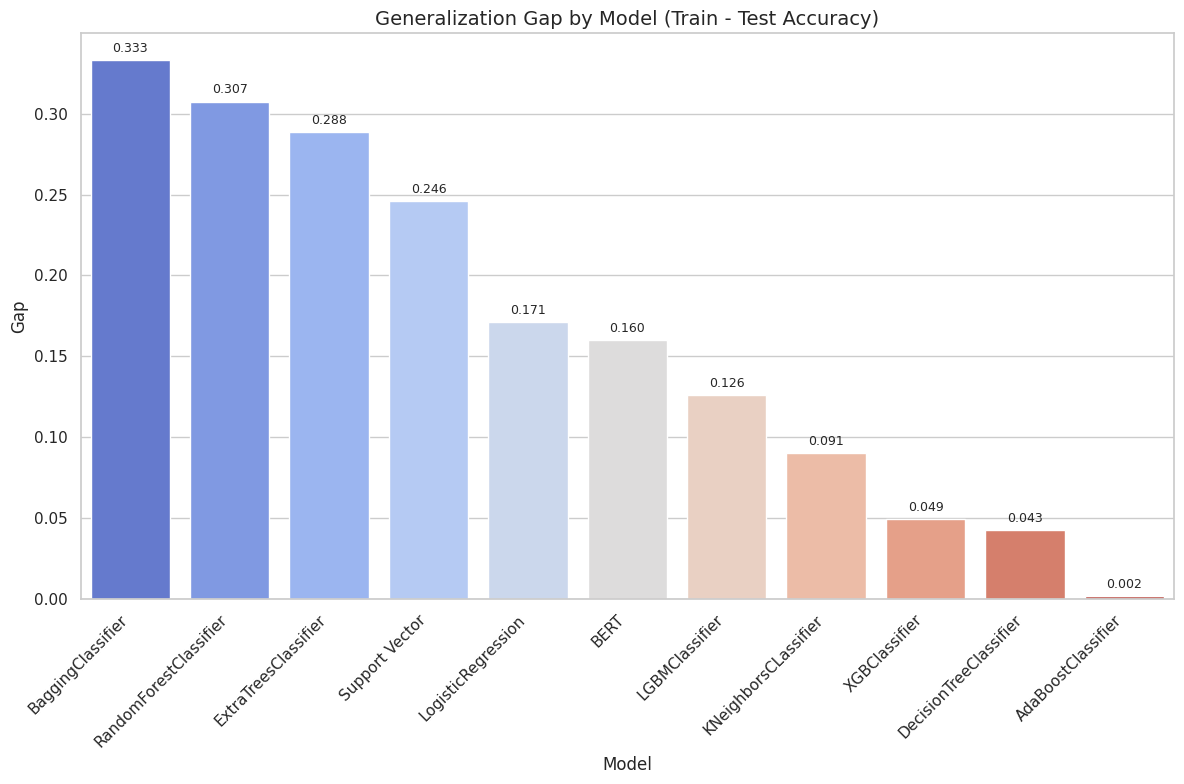

In [ ]:
plt.figure(figsize=(12, 8))
# Plot generalization gap
sns.barplot(data=combined_results.reset_index(), x='Model', y='Gen. Gap', palette='coolwarm')
plt.title('Generalization Gap by Model (Train - Test Accuracy)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Gap', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(combined_results['Gen. Gap']):
    plt.text(
        i,
        v + 0.005,
        f'{v:.3f}',
        ha='center',
        fontsize=9
    )
plt.tight_layout()
plt.show()

##Comparing compuational time across all the models

In [ ]:
# Sort by training time
train_time_order = combined_results.sort_values('train time').index.tolist()
train_time_df = combined_results.copy()
train_time_df['Model'] = pd.Categorical(train_time_df.index, categories=train_time_order, ordered=True)

In [ ]:
# Sort by inference time
inference_time_order = combined_results.sort_values('Inference time').index.tolist()
inference_time_df = combined_results.copy()
inference_time_df['Model'] = pd.Categorical(inference_time_df.index, categories=inference_time_order, ordered=True)

<ipython-input-64-98be36a5fbb3>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-64-98be36a5fbb3>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1600x800 with 0 Axes>

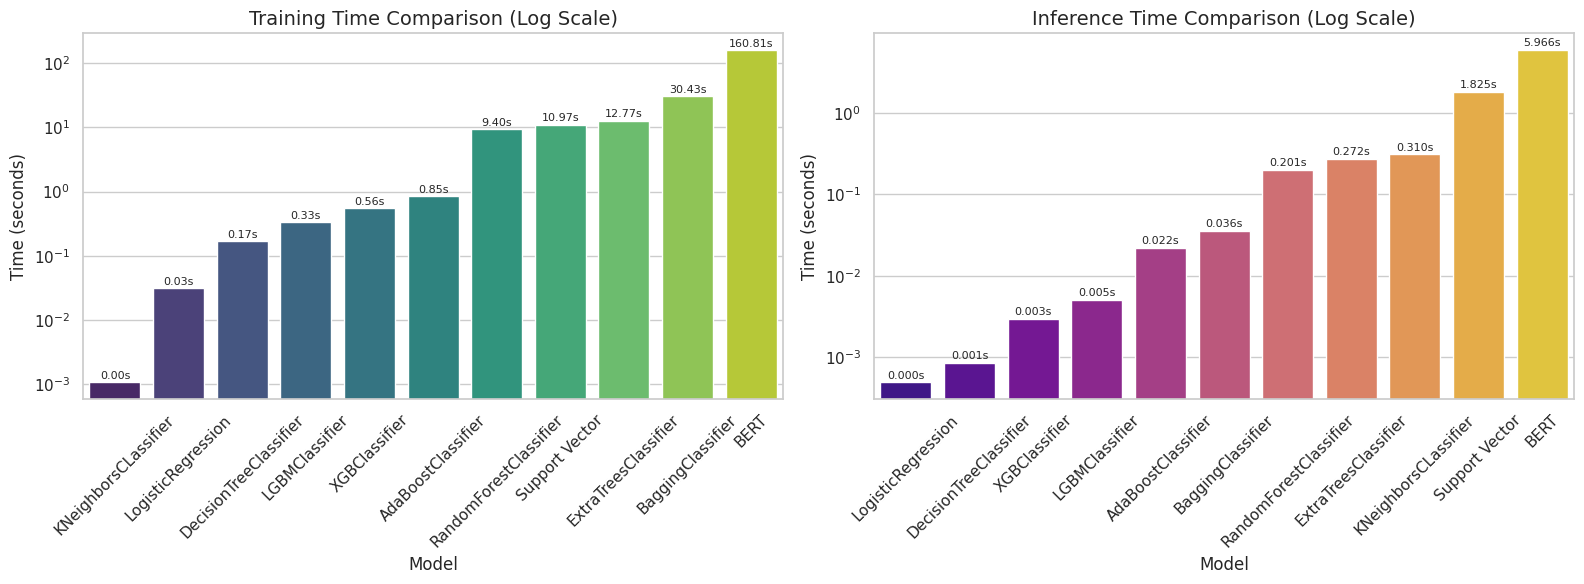

In [ ]:
plt.figure(figsize=(16, 8))
# subplots
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 6))
# Training time plot (log scale)
sns.barplot(data=train_time_df, x='Model', y='train time', ax=ax2, palette='viridis')
ax2.set_title('Training Time Comparison (Log Scale)', fontsize=14)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(
        f'{height:.2f}s',
        (p.get_x() + p.get_width() / 2., height*1.05),
        ha='center',
        va='bottom',
        fontsize=8
    )

# Inference time plot (log scale)
sns.barplot(data=inference_time_df, x='Model', y='Inference time', ax=ax3, palette='plasma')
ax3.set_title('Inference Time Comparison (Log Scale)', fontsize=14)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Time (seconds)', fontsize=12)
ax3.set_yscale('log')
ax3.tick_params(axis='x', rotation=45)
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(
        f'{height:.3f}s',
        (p.get_x() + p.get_width() / 2., height*1.05),
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

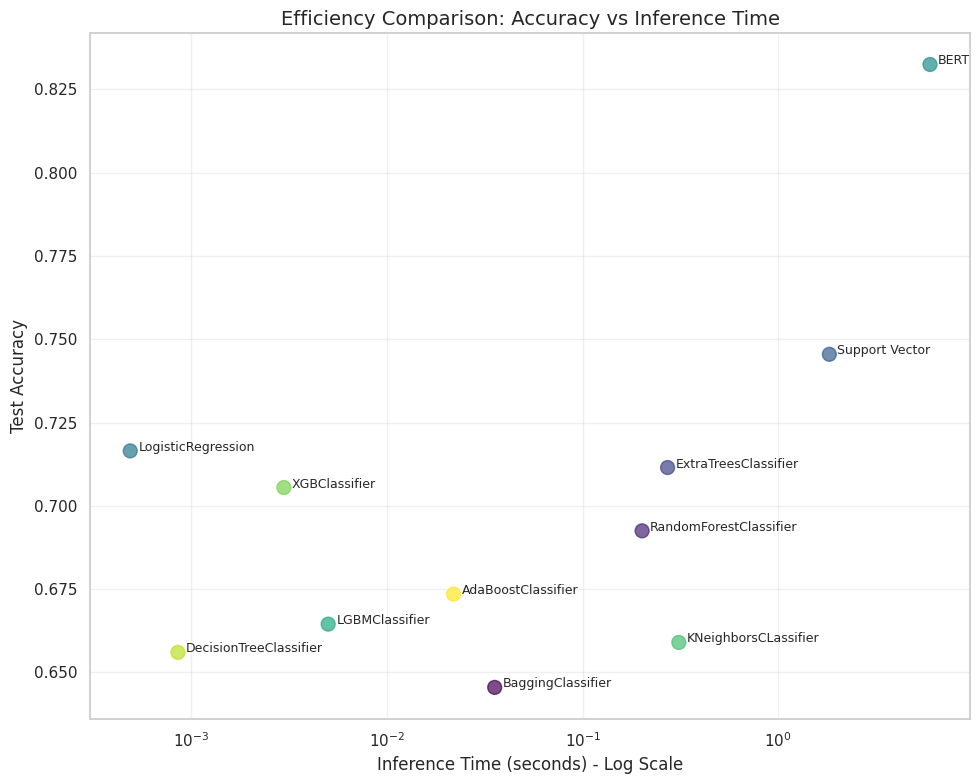

In [ ]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

combined_results = combined_results.reset_index()

# Create efficiency scatter plot
plt.scatter(
    combined_results['Inference time'],
    combined_results['Test Score'],
    s=100,
    alpha=0.7,
    c=np.arange(len(combined_results)),
    cmap='viridis'
)

# Add algorithm labels to the points
for i, alg in enumerate(combined_results['Model']):
    plt.annotate(
        alg,
        (combined_results['Inference time'].iloc[i]*1.1, combined_results['Test Score'].iloc[i]),
        fontsize=9
    )

plt.xscale('log')
plt.xlabel('Inference Time (seconds) - Log Scale', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Efficiency Comparison: Accuracy vs Inference Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Loading BERT

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# === Hyperparameters (Best-found) ===
BEST_PARAMS = {
    'learning_rate': 3e-5,
    'batch_size': 32,
    'epochs': 5,
    'max_length': 128,
    'model_name': 'bert-base-uncased',
    'save_dir': './best_bert_model'
}


df = sampled_df.copy()
df['label'] = df['scoreSentiment'].astype(int)

# First split: train+val and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['reviewText'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)
# Second split: train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# === Tokenizer and Encoding ===
tokenizer = BertTokenizer.from_pretrained(BEST_PARAMS['model_name'])

def encode_texts(texts, max_length):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

train_enc = encode_texts(train_texts, BEST_PARAMS['max_length'])
val_enc   = encode_texts(val_texts, BEST_PARAMS['max_length'])
test_enc  = encode_texts(test_texts, BEST_PARAMS['max_length'])

# === Create TensorFlow Datasets ===
def make_dataset(encodings, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((
        {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']},
        labels.values
    ))
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_enc, train_labels, BEST_PARAMS['batch_size'])
val_ds   = make_dataset(val_enc,   val_labels,   BEST_PARAMS['batch_size'])
test_ds  = make_dataset(test_enc,  test_labels,  BEST_PARAMS['batch_size'])

# === Build and Compile Model ===
model = TFBertForSequenceClassification.from_pretrained(
    BEST_PARAMS['model_name'],
    num_labels=2
)
optimizer = tf.keras.optimizers.Adam(learning_rate=BEST_PARAMS['learning_rate'])
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics   = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=BEST_PARAMS['epochs']
)

# === Evaluate on Test Set ===
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# === Save Model and Tokenizer ===
os.makedirs(BEST_PARAMS['save_dir'], exist_ok=True)
model.save_pretrained(BEST_PARAMS['save_dir'])
tokenizer.save_pretrained(BEST_PARAMS['save_dir'])
print(f"Model and tokenizer saved to: {BEST_PARAMS['save_dir']}")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
200/200 [==============================] - 74s 161ms/step - loss: 0.4430 - accuracy: 0.7945 - val_loss: 0.3517 - val_accuracy: 0.8406
Epoch 2/5
200/200 [==============================] - 21s 106ms/step - loss: 0.2540 - accuracy: 0.9016 - val_loss: 0.4077 - val_accuracy: 0.8506
Epoch 3/5
200/200 [==============================] - 21s 106ms/step - loss: 0.1659 - accuracy: 0.9430 - val_loss: 0.4575 - val_accuracy: 0.8388
Epoch 4/5
200/200 [==============================] - 21s 106ms/step - loss: 0.0875 - accuracy: 0.9705 - val_loss: 0.5076 - val_accuracy: 0.8419
Epoch 5/5
63/63 [==============================] - 2s 40ms/step - loss: 0.6694 - accuracy: 0.8335
Test Accuracy: 0.8335, Test Loss: 0.6694
Model and tokenizer saved to: ./best_bert_model


In [ ]:
# 1. Compress the folder into a single .zip
!zip -r best_bert_model.zip best_bert_model

# 2. Bring up a browser download dialog
from google.colab import files
files.download('best_bert_model.zip')

  adding: best_bert_model/ (stored 0%)
  adding: best_bert_model/special_tokens_map.json (deflated 42%)
  adding: best_bert_model/tokenizer_config.json (deflated 75%)
  adding: best_bert_model/vocab.txt (deflated 53%)
  adding: best_bert_model/config.json (deflated 48%)
  adding: best_bert_model/tf_model.h5 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>